# Assess Distance Metrics

Can we predict which molecules would be most likely to have large errors? We are going to focus on the atomic contribution model, as it is the one that we find to have the best performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multiprocessing import Pool
from util import has_stereoisomers
from scipy.stats import sem
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Results
We computed the error for different molecules in the hold-out sets and distance metrics based on their models

In [2]:
data = dict((x, pd.read_csv(os.path.join('test-sets-with-dists', f'{x}.csv'))) for x in ['molecular-fingerprint', 'atomic-contribution'])

In [3]:
subset = data['atomic-contribution']

## Plot Different Metrics
Get an idea for how well they work

### Tanimoto Similarity
Assess outliers for the molecular fingerprint

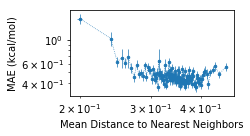

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
dist_col = f'tan_sim_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                       for s in np.array_split(subset.sort_values(dist_col), 128)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', 
            markersize=2.5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

*Finding*: We do at least see a positive correlation

### Molecular Fingerprint
Assess outliers for the molecular fingerprint

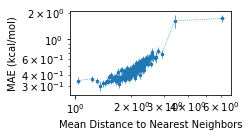

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=4
dist_col = f'train_dist_mol_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                       for s in np.array_split(subset.sort_values(dist_col), 128)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', 
            markersize=2.5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

### Atomic-Level Features
We define the distance between molecules as the average distance of each atomic representation

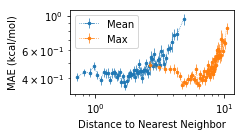

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
for t in ['mean', 'max']:
    dist_col = f'train_dist_atom_{t}_{n}'
    dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                           for s in np.array_split(subset.sort_values(dist_col), 64)[2:]])

    ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=t.capitalize(), marker='o', 
                markersize=2.5, linestyle=':', lw=0.7)
ax.legend()
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Distance to Nearest Neighbor')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance_atomic.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance_atomic.eps'))

*Finding*: Monotonic increase for the mean slope

Determine a "cutoff for the total error?

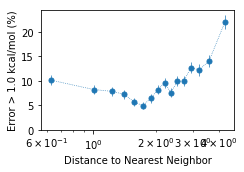

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

n=64
error_cutoff = 1 # kcal/mol
dist_col = f'train_dist_atom_mean_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(
    *[(np.mean(s[dist_col]), sem(s[dist_col]), 
       np.mean(s['sol_acn_error'].abs() > error_cutoff) * 100, 
       sem(s['sol_acn_error'].abs() > error_cutoff) * 100) 
      for s in np.array_split(subset.sort_values(dist_col), 16)]
)

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem,
            label=f'k={n}', marker='o', 
            markersize=5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_xlabel('Distance to Nearest Neighbor')
ax.set_ylim(0)
ax.set_ylabel(f'Error >{error_cutoff: 0.1f} kcal/mol (%)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-liklihood-bad.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-liklihood-bad.eps'))

*Finding*: We can establish cutoff for "I'm expecting this error to be large"

## Plot all Three Metrics
Normalize the distances and see which performs better

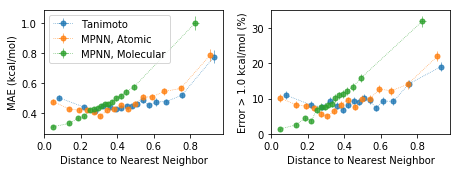

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

# Plot configuration
n = 64
error_cutoff = 1 # kcal/mol
n_bins = 16

# Plot each metric
for label, col in zip(['Tanimoto', 'MPNN, Atomic', 'MPNN, Molecular'],
                     [f'tan_sim_{n}', f'train_dist_atom_mean_{n}', f'train_dist_mol_{n}']):
    # Order the molecules by ascending "badness"
    if col.startswith('tan_sim'):
        dist = 1.0 - subset[col].values
    else:
        dist = subset[col].values
    order = np.argsort(dist)
    dist = dist[order]
    error = np.abs(subset['sol_acn_error'].values[order])
    
    # Normalize the distances by percentile
    normed_dists = (dist - np.percentile(dist, 1)) / (np.percentile(dist, 99) - np.percentile(dist, 1))
    
    # Bin by distance
    dist_mean, dist_sem, err_mean, err_sem, prob_mean, prob_sem = zip(
        *[(np.mean(s[:, 0]), sem(s[:, 0]), 
           np.mean(s[:, 1]), sem(s[:, 1]),
           np.mean(s[:, 1] > error_cutoff) * 100, 
           sem(s[:, 1] > error_cutoff) * 100) 
          for s in np.array_split(np.vstack((normed_dists, error)).T, n_bins)]
    )

    axs[0].errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem,
                label=label, marker='o', alpha=0.8,
                markersize=5, linestyle=':', lw=0.7)
    axs[1].errorbar(dist_mean, prob_mean, xerr=dist_sem, yerr=prob_sem,
                label=label, marker='o', alpha=0.8,
                markersize=5, linestyle=':', lw=0.7)

# Label axes and such
axs[0].legend()
#axs[0].set_yscale('log')
#ax.set_xscale('log', basex=10)
axs[1].set_ylim(0)

for ax in axs:
    ax.set_xlabel('Distance to Nearest Neighbor')
axs[0].set_ylabel('MAE (kcal/mol)')
axs[1].set_ylabel(f'Error >{error_cutoff: 0.1f} kcal/mol (%)')


fig.tight_layout()
fig.savefig(os.path.join('figures', 'distance-metrics.png'), dpi=320)
fig.savefig(os.path.join('figures', 'distance-metrics.eps'))

*Finding*: Measuring distance with the MPNN feature set seems to be our best way of detecting which prediction are most likely to be faulty